In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
data = pd.read_csv("price_smp (1).csv", encoding='latin-1')
data2 = np.loadtxt("price_smp (1).csv",encoding='latin-1', delimiter=',', skiprows=1, usecols=(10, 11, 12), dtype=float)

df = data.iloc[:, [11, 12, 13]]  
df.columns = ['11', '12', '13']

In [25]:
print(df.describe())

                11           12           13
count   365.000000   365.000000   365.000000
mean   1040.311233  1040.311507  1040.312329
std     105.147265   105.147065   105.146765
min     885.700000   885.700000   885.700000
25%     988.400000   988.400000   988.400000
50%    1022.600000  1022.600000  1022.600000
75%    1061.500000  1061.500000  1061.500000
max    1565.500000  1565.500000  1565.500000


**EDA**

In [26]:
df.isna().mean()

11    0.0
12    0.0
13    0.0
dtype: float64

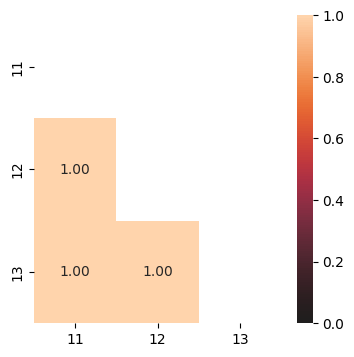

In [27]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df.corr(), mask=mask, vmax=1, vmin=0, center=0,annot=True,fmt='.2f');

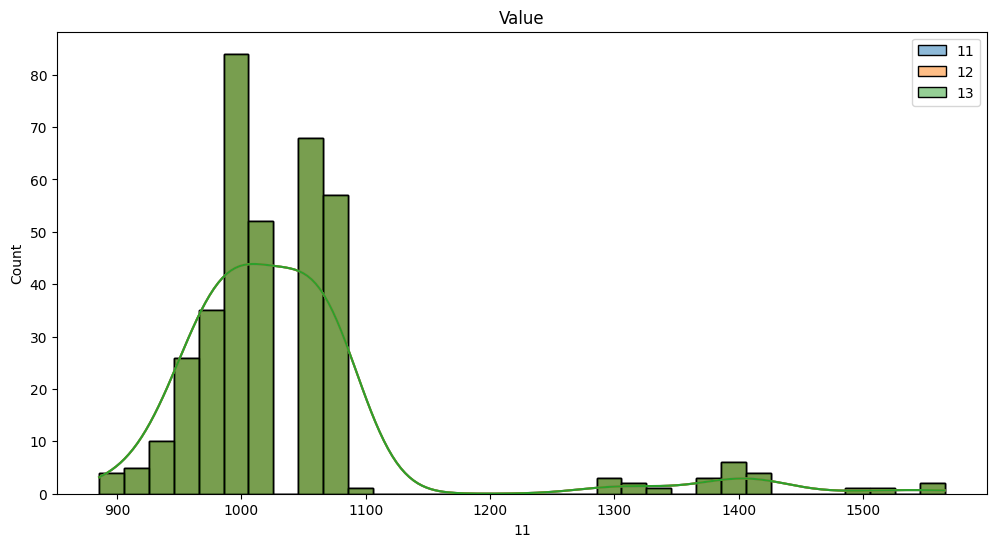

In [28]:
# biểu đồ phân phối
plt.figure(figsize=(12, 6))
sns.histplot(df['11'], kde=True, label='11')
sns.histplot(df['12'], kde=True, label='12')
sns.histplot(df['13'], kde=True, label='13')
plt.legend()
plt.title('Value')
plt.show()


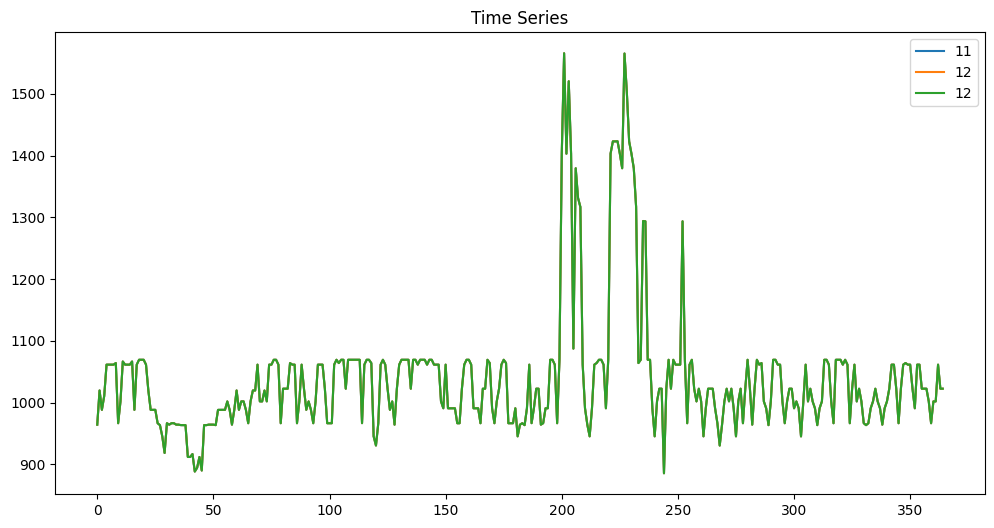

In [29]:
# biểu đồ thời gian
plt.figure(figsize=(12, 6))
plt.plot(df['11'], label='11')
plt.plot(df['12'], label='12')
plt.plot(df['12'], label='12')
plt.legend()
plt.title('Time Series')
plt.show()


**Kalman Model**

In [30]:
# Khởi tạo biến trạng thái (state vector)
x = np.zeros((3, 1))  # 3 biến trạng thái tương ứng với 3 cột

# Ma trận hiệp phương sai của trạng thái (covariance matrix)
P = np.eye(3)

# Ma trận chuyển tiếp trạng thái (state transition matrix)
F = np.eye(3)

# Ma trận đo lường (measurement matrix)
H = np.eye(3)

# Hiệp phương sai của nhiễu quá trình (process noise covariance)
Q = np.eye(3) * 0.01

# Hiệp phương sai của nhiễu đo lường (measurement noise covariance)
R = np.eye(3) * 0.1

# Vector đo lường (measurement vector)
z = np.zeros((3, 1))


In [31]:
def predict(x, P, F, Q):
    # Dự đoán trạng thái tiếp theo
    x = np.dot(F, x)
    P = np.dot(F, np.dot(P, F.T)) + Q
    return x, P

def update(x, P, z, H, R):
    # Tính toán các giá trị Kalman Gain
    y = z - np.dot(H, x)
    S = np.dot(H, np.dot(P, H.T)) + R
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))

    # Cập nhật trạng thái và hiệp phương sai
    x = x + np.dot(K, y)
    P = P - np.dot(K, np.dot(H, P))
    return x, P


In [32]:
filtered_data2 = []

for measurement in data2:
    z = measurement.reshape(3, 1)  # Chuyển đổi đo lường thành vector cột

    # Dự đoán bước tiếp theo
    x, P = predict(x, P, F, Q)

    # Cập nhật với đo lường mới
    x, P = update(x, P, z, H, R)

    # Lưu trữ kết quả đã lọc
    filtered_data2.append(x.flatten())

filtered_data2 = np.array(filtered_data2)


In [33]:
print(filtered_data2)


[[ 877.51711712  877.51711712  877.51711712]
 [ 948.95907665  948.95907665  948.95907665]
 [ 963.78734581  963.78734581  963.78734581]
 ...
 [1020.3193141  1020.3193141  1020.3193141 ]
 [1020.93545556 1020.93545556 1020.93545556]
 [1021.38514258 1021.38514258 1021.38514258]]


In [34]:
mse_kalman = mean_squared_error(data2, filtered_data2)
mae_kalman = mean_absolute_error(data2, filtered_data2)
rmse_kalman = np.sqrt(mse_kalman)

print("Kalman Filter - MSE:", mse_kalman)
print("Kalman Filter - MAE:", mae_kalman)
print("Kalman Filter - RMSE:", rmse_kalman)

Kalman Filter - MSE: 2795.5439642485017
Kalman Filter - MAE: 32.4418126209985
Kalman Filter - RMSE: 52.87290387569517


In [38]:
from sklearn.mixture import BayesianGaussianMixture

BGM = BayesianGaussianMixture(n_components=3,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(df)
df["Clusters"]= preds

C:\Users\Admin\AppData\Local\Temp\ipykernel_20968\3779203059.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Clusters"]= preds
